<div class="title">Supervised Learning: Case Study</div>
<div class="subtitle">Machine Learning</div>
<div class="author">Carlos María Alaíz Gudín &mdash; Universidad Autónoma de Madrid</div>

---
<div style="font-size: large; font-weight: bold; margin-left: 6em;"><p>Team Number and Names: <u>3: Enrique Juliá Arévalo, Sara Verde Camacho, Leo Pérez Peña</u></div>


**Configuration**

This cell defines the general configuration of Jupyter Notebook.

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

This cell imports the packages to be used.

In [23]:
# Standard packages.
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys


# Custom packages.
from ml import (
	evaluate_model_clas,
	plot_dataset_clas,
	save_predictions,
	show_function,
)

# Initialisations.
matplotlib.rc("figure", figsize=(15, 5))
sys.dont_write_bytecode = True

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.model_selection import GridSearchCV


# Supervised Learning Case Study

## Introduction

This practical assignment is designed as a **Kaggle competition**.

Specifically, a **multiclass classification** dataset will be used, so that each team will compete to improve their predictions over an unlabeled partition of the dataset.

It is important to remark that **the grades will not depend on the obtained ranking**, but on the different approaches used to tackle the problem, on the design of the experiments and on the analysis of the results.

## Rubric

The following aspects will be taken into account when evaluating the assignment.


* Analyse the data.


* Preprocess the features automatically using *pipelines*.


* Adjust the hyper-parameters with a validation stage.


* Try different models to improve the performance, at least:
    * (Regularized) Logistic Regression.
    * SVC.
    * ANNs.


* Try interpretable models to check the important features (e.g. Lasso).


* Submit the prediction several times (the evolution of the performance will be also considered).


* Any other approach that may improve either the performance or interpretability of the model (e.g. feature selection, ensembles...).


* Analyse the results obtained after each experiment, and make decisions following the conclusions.

## Utilities

Some utilities are given next as a starting point, but the teams can define any other tools that they may need.

### Team Number

The **number of the team** should be inserted here, so that the file of predictions has the appropriate name.

In [3]:
################################################################################
# The team number should be inserted here:
team_number = 3
################################################################################

### Evaluation of the Model

The following function evaluates a multiclass model (already fitted), computing and showing the accuracy and balanced accuracy over both the training and test partitions.

In [4]:
show_function(evaluate_model_clas)

```python
def evaluate_model_clas(model, x_tr, y_tr, x_te, y_te, print_table=True):
    y_tr_p = model.predict(x_tr)
    y_te_p = model.predict(x_te)

    er_tr = [accuracy_score(y_tr, y_tr_p), balanced_accuracy_score(y_tr, y_tr_p)]
    er_te = [accuracy_score(y_te, y_te_p), balanced_accuracy_score(y_te, y_te_p)]

    ers = [er_tr, er_te]
    headers = ["Acc", "Bal. Acc"]

    if print_table:
        print("{:>15}".format(""), end="")
        for h in headers:
            print("{:>15}".format(h), end="")
        print("")

        headers_col = ["Train", "Test"]

        cnt = 0
        for er in ers:
            hc = headers_col[cnt]
            cnt = cnt + 1
            print("{:<15}".format(hc), end="")

            for e in er:
                print("{:15.2f}".format(e), end="")
            print("")

    return ers
```

### Submission of the Predictions

The following function saves the predictions on the **challenge partition** to a file with syntax `Team_TT_YYYYMMDD-HHMMSS.pred`, where `TT` stands for the team number, and `YYYYMMDD-HHMMSS` is a timestamp to distinguish the different submissions of a team.

In [5]:
show_function(save_predictions)

```python
def save_predictions(y_ch_p, team_number, n_preds=500):
    if len(y_ch_p) != n_preds:
        print(
            "Error saving the predictions, it should be a vector of %d lables" % n_preds
        )
    else:
        time_str = time.strftime("%Y%m%d-%H%M%S")
        np.savetxt("Team_{:02d}_{}.txt".format(team_number, time_str), y_ch_p, fmt="%d")
```

Once the prediction file has been generated, it can be uploaded to Moodle.
It is important to **avoid renaming the files**.

## Dataset

A real dataset will be tackled in this practical assignment.
In particular, the [fetal health](https://www.kaggle.com/andrewmvd/fetal-health-classification) dataset of Kaggle, that aims to classify the fetal health in three classes:
1. Normal.
2. Suspect.
3. Pathological.

The input data are a set of $21$ variables extracted from the cardiotocographies (CTGs).

### Load of the Dataset

This cell loads the data, in particular three partitions:
1. A training partition, given by `x_tr` and `y_tr`, to train (and validate) the models.
2. A test partition, given by `x_te` and `y_te`, to estimate the performance of the model.
3. A challenge partition, given by `x_ch`. The real labels are unknown, and hence the predictions should be submitted to know the real performance of the model.

In [6]:
prefix = "./data/fetal_health"

x_tr = np.loadtxt(prefix + "_tr.dat")
x_te = np.loadtxt(prefix + "_te.dat")
x_ch = np.loadtxt(prefix + "_ch.dat")

y_tr = np.loadtxt(prefix + "_tr.lab")
y_te = np.loadtxt(prefix + "_te.lab")

features = [line.rstrip("\n") for line in open("./data/fetal_health.head")]
n_features = len(features)

### Initial Incomplete Analysis

Plot of the data over the first two features.

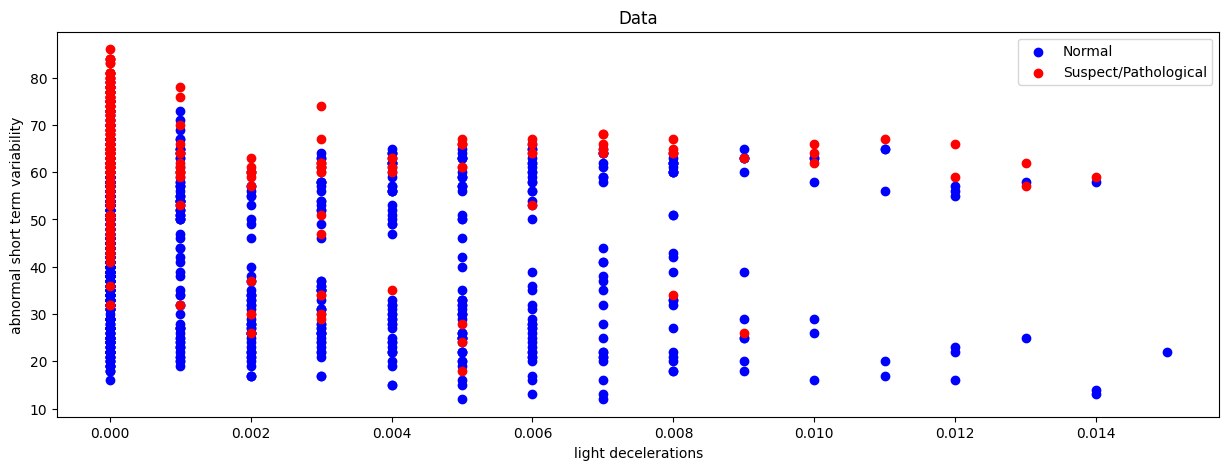

In [7]:
y_tr_binary = y_tr.copy()
y_tr_binary[y_tr == 3] = 2
plot_dataset_clas(x_tr, y_tr_binary)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.legend(["Normal", "Suspect/Pathological"])
plt.axis("auto")
plt.show()

Balance of the dataset.

In [8]:
for lab in np.unique(y_tr):
    n_sam = np.sum(y_tr == lab)
    print(
        "Class {}: {:3d} samples ({:5.2f}%)".format(
            lab, n_sam, 100.0 * n_sam / len(y_tr)
        )
    )

Class 1.0: 877 samples (77.89%)
Class 2.0: 156 samples (13.85%)
Class 3.0:  93 samples ( 8.26%)


Con este análisis, lo primero que vemos es que las clases no están balanceadas. Por tanto, fijarnos únicamente en el valor de accuracy no tiene sentido, ya que en este caso se trata de una medida engañosa. Por ejemplo, si la clase mayoritaria constituye casi un 80% de los datos, un modelo que siempre predice la clase mayoritaria tendrá una precisión de casi 0.8, a pesar de no estar aprendiendo nada acerca del conjunto de datos. 

Por eso, debemos prestarle más atención al valor de balanced accuracy, que se calcula dándole la misma importancia a todas las clases.

Esto que acabamos de comentar se pone de manifiesto al utilizar el clasificador DummyClasifier, utilizando la estrategia de predecir la clase más frecuente: 

In [34]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_tr, y_tr)
_ = evaluate_model_clas(dummy_clf, x_tr, y_tr, x_te, y_te)

                           Acc       Bal. Acc
Train                     0.78           0.33
Test                      0.78           0.33


Al calcular la balanced accuracy, se ve claramente que, a pesar de tener una precisión 0.78, solo se está prediciendo correctamente una de las clases.

In [ ]:
y_ch = dummy_clf.predict(x_ch)
# save_predictions(y_ch, 3)

HABRÍA QUE VER SI HAY VARIABLES IRRELEVANTES O REDUNDANTES. SE PUEDE HACER UNA REDUCCIÓN DE LA DIMENSIONALIDAD CON PCA O UTILIZAR SELECTKBEST COMO EN LA PRÁCTICA ANTERIOR.

TAMBIÉN FALTA EXPLICAR BIEN CADA UNO DE LOS MODELOS QUE ESTAMOS UTILIZANDO, SOLO ESTÁ EL CÓDIGO.

## Regresión logística

Como ahora sí se tendrá en cuenta el input, los datos deben normalizarse.

Ajustamos el clasificador, esta es una primera aproximación, pero se repetirá el análisis introduciendo los pasos en una Pipeline.

Observamos que, en comparación con el Dummy classifier, se ha mejorado en gran medida la precisión de predicción.

In [35]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])
pipeline.fit(x_tr, y_tr)
_ = evaluate_model_clas(pipeline, x_tr, y_tr, x_te, y_te)


                           Acc       Bal. Acc
Train                     0.91           0.82
Test                      0.90           0.79


In [ ]:
y_ch = pipeline.predict(x_ch)
# save_predictions(y_ch, 3)

# Ridge regression


se hace con logistic regression tb !! cambiar la penalty

In [36]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty="l2"))
])
pipeline.fit(x_tr, y_tr)
_ = evaluate_model_clas(pipeline, x_tr, y_tr, x_te, y_te)

                           Acc       Bal. Acc
Train                     0.91           0.82
Test                      0.90           0.79


Lasso

In [37]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty="l1", solver="saga", max_iter=2000))
])
pipeline.fit(x_tr, y_tr)
_ = evaluate_model_clas(pipeline, x_tr, y_tr, x_te, y_te)

                           Acc       Bal. Acc
Train                     0.92           0.82
Test                      0.90           0.80


Elastic net

In [44]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty="elasticnet", l1_ratio=0.5, solver="saga", max_iter=2000))
])
pipeline.fit(x_tr, y_tr)
_ = evaluate_model_clas(pipeline, x_tr, y_tr, x_te, y_te)

                           Acc       Bal. Acc
Train                     0.92           0.82
Test                      0.90           0.79
